## Vertical integration for paired datasets

uniPort also involves a vertical integration method for paired-cell datasets. Here we use uniPort to integrates paired SNARE-seq CellLineMixture datasets from [GSE126074](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126074).

In [1]:
import uniport as up
import numpy as np
import pandas as pd
import scanpy as sc
import episcanpy as epi
from sklearn.preprocessing import MinMaxScaler

In [2]:
labels = pd.read_csv('snare/cell_line_meta.txt', sep='\t')
celltype = labels['cell_line'].values

In [3]:
adata_peaks = up.load_file('snare/GSE126074_CellLineMixture_SNAREseq_chromatin_counts.tsv')
adata_rna = up.load_file('snare/GSE126074_CellLineMixture_SNAREseq_cDNA_counts.tsv')
print(adata_peaks)
print(adata_rna)

AnnData object with n_obs × n_vars = 1047 × 136771
AnnData object with n_obs × n_vars = 1047 × 18666


In [4]:
adata_peaks.obs['cell_type'] = celltype
adata_peaks.obs['domain_id'] = 0
adata_peaks.obs['domain_id'] = adata_peaks.obs['domain_id'].astype('category')
adata_peaks.obs['source'] = 'ATAC'

adata_rna.obs['cell_type'] = celltype
adata_rna.obs['domain_id'] = 1
adata_rna.obs['domain_id'] = adata_rna.obs['domain_id'].astype('category')
adata_rna.obs['source'] = 'RNA'

Preprocess scATAC-seq peaks. Select 2,000 highly variable peaks.

In [5]:
adata_peaks.X[adata_peaks.X>1] = 1
epi.pp.select_var_feature(adata_peaks, nb_features=2000, show=False, copy=False)
sc.pp.normalize_total(adata_peaks)
up.batch_scale(adata_peaks)
print(adata_peaks)

AnnData object with n_obs × n_vars = 1047 × 2070
    obs: 'cell_type', 'domain_id', 'source'
    var: 'n_cells', 'prop_shared_cells', 'variability_score'


Preprocess scRNA-seq peaks. Select 2,000 highly variable genes.

In [6]:
sc.pp.normalize_total(adata_rna)
sc.pp.log1p(adata_rna)
sc.pp.highly_variable_genes(adata_rna, n_top_genes=2000, inplace=False, subset=True)
up.batch_scale(adata_rna)
print(adata_rna)

AnnData object with n_obs × n_vars = 1047 × 2000
    obs: 'cell_type', 'domain_id', 'source'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


Project scATAC-seq into latent space with the help of scRNA-seq. The latent representations of scATAC-seq are stored at `adata_atac.obs['latent']`

In [7]:
adata_peaks = up.Run(adatas=[adata_peaks, adata_rna], mode='v', lr=0.001, iteration=10000)

Dataset 0: ATAC
AnnData object with n_obs × n_vars = 1047 × 2070
    obs: 'cell_type', 'domain_id', 'source'
    var: 'n_cells', 'prop_shared_cells', 'variability_score'
Dataset 1: RNA
AnnData object with n_obs × n_vars = 1047 × 2000
    obs: 'cell_type', 'domain_id', 'source'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
Reference dataset is dataset 1




Epochs: 100%|████████████████████████████| 2500/2500 [16:26<00:00,  2.53it/s, recon_loss=239.627,kl_loss=7.374]


Perform UMAP visualization for scATAC before vertical integration. 

... storing 'cell_type' as categorical
... storing 'source' as categorical


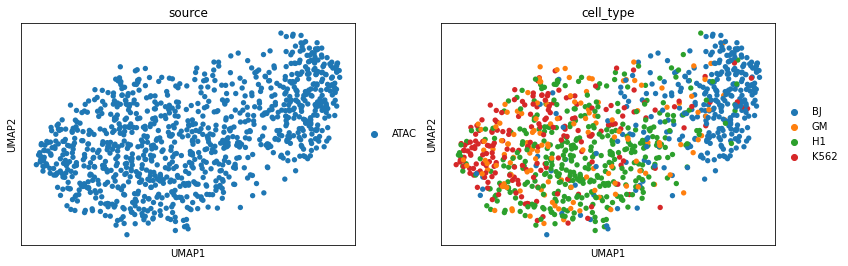

In [8]:
sc.pp.pca(adata_peaks)
sc.pp.neighbors(adata_peaks)
sc.tl.umap(adata_peaks, min_dist=0.1)
sc.pl.umap(adata_peaks, color=['source', 'cell_type'])

Perform UMAP visualization for scRNA. 

... storing 'cell_type' as categorical
... storing 'source' as categorical


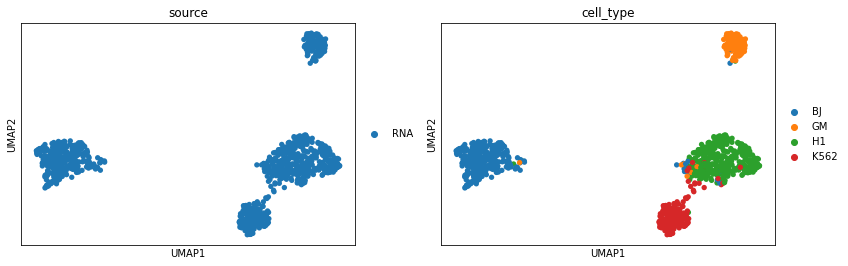

In [9]:
sc.pp.pca(adata_rna)
sc.pp.neighbors(adata_rna)
sc.tl.umap(adata_rna, min_dist=0.1)
sc.pl.umap(adata_rna, color=['source', 'cell_type'])

Perform UMAP visualization for scATAC latent representations after vertical integration. The cell types of scATAC-seq now are more distinguishable than before. 

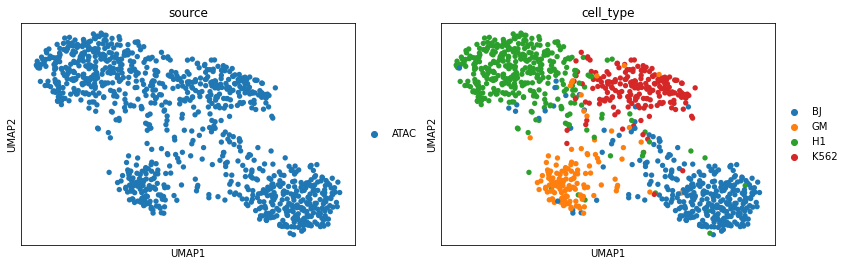

In [10]:
sc.pp.neighbors(adata_peaks, use_rep='latent')
sc.tl.umap(adata_peaks, min_dist=0.1)
sc.pl.umap(adata_peaks, color=['source', 'cell_type'])